# I. Loading Data

## A. Embeddings were created using the technique from the notebook ["Measuring Document Similarity with LLMs"](https://colab.research.google.com/drive/1-aOfk6mVFUA3PH_s6P-lCaM9xKLJ0dLz?usp=sharing) by Greg Yauney, Melanie Walsh, and [The AI for Humanists](https://www.aiforhumanists.com/) team.

## B. Each line loads an Excel file containing embeddings of Old Testament verses from different models:
* [E5-Large](https://huggingface.co/intfloat/multilingual-e5-large): A multilingual embedding model.
* [AlephBERT](https://huggingface.co/onlplab/alephbert-base): A Hebrew language model.
* [LaBSE](https://huggingface.co/sentence-transformers/LaBSE): A language-agnostic model that provides sentence embeddings.
* [MPNet](https://huggingface.co/sentence-transformers/all-mpnet-base-v2): A pre-trained transformer model known for capturing sentence similarities.
* [LLaMA 3](https://huggingface.co/meta-llama/Llama-3.1-70B): A large transformer-based model (likely multilingual or specific to language processing tasks).

In [5]:
import pandas as pd
import numpy as np

chr_parallels = pd.read_excel("./data/Chronicles Parallels.xlsx", usecols = ["Parallel_Ref", "Chr_Ref"])

e5_large_emb = pd.read_excel("./data/Chr_Kgs_Sam_vss_intfloat_multilingual_e5_large.xlsx") # updated
alephbert_emb = pd.read_excel("./data/Chr_Kgs_Sam_alephbert.xlsx") # updated
labse_emb = pd.read_excel("./data/Chr_Kgs_Sam_labse.xlsx") # updated
mpnet_emb = pd.read_excel("./data/Chr_Kgs_Sam_mpnet.xlsx") # updated
llama3_emb = pd.read_excel("./data/Chr_Kgs_Sam_vss_llama3.xlsx") # updated

In [6]:
e5_large_emb.head()

,Abbrev_Verse,Book,Chapter,Verse,Text,0,1,2,3,4,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1 Sam 1:1,1 Samuel,1,1,וַיְהִי אִישׁ אֶחָד מִן־הָרָמָתַיִם צוֺפִים מֵ...,0.023746,-0.000017,-0.021127,-0.022794,0.012275,...,-0.034309,-0.011159,0.028808,0.016023,0.006324,0.020373,-0.016878,0.005842,-0.020792,0.036934
1,1 Sam 1:2,1 Samuel,1,2,וְלוֺ שְׁתֵּי נָשִׁים שֵׁם אַחַת חַנָּה וְשֵׁם...,0.028873,0.015343,-0.031174,-0.010348,0.003222,...,-0.001235,-0.033107,0.028567,-0.023815,0.005752,0.029410,0.007342,0.002840,-0.021763,0.030894
2,1 Sam 1:3,1 Samuel,1,3,וְעָלָה הָאִישׁ הַהוּא מֵעִירוֺ מִיָּמִים יָמִ...,0.029160,0.015032,-0.017895,-0.012928,0.012631,...,-0.021197,-0.025950,0.018698,-0.007042,0.002789,0.030528,0.021185,-0.011402,-0.035138,0.032907
3,1 Sam 1:4,1 Samuel,1,4,וַיְהִי הַיּוֺם וַיִּזְבַּח אֶלְקָנָה וְנָתַן ...,0.035581,-0.006419,-0.025746,-0.013345,0.007959,...,-0.034911,-0.025637,0.024569,0.001526,0.010833,0.043457,-0.004918,0.013415,-0.024605,0.025240
4,1 Sam 1:5,1 Samuel,1,5,וּלְחַנָּה יִתֵּן מָנָה אַחַת אַפָּיִם כִּי אֶ...,0.016861,0.018552,-0.027504,-0.015005,0.015923,...,-0.009470,-0.016183,0.021681,-0.007989,-0.001479,0.034632,0.012303,0.008708,-0.055898,0.031904


In [7]:
chr_parallels.head()

,Chr_Ref,Parallel_Ref
0,1 Chr 3:1,2 Sam 3:2
1,1 Chr 3:1,2 Sam 3:3
2,1 Chr 3:2,2 Sam 3:3
3,1 Chr 3:2,2 Sam 3:4
4,1 Chr 3:3,2 Sam 3:4


# II. Computing Similiarities for Parallel and Non-Parallels

* The code **computes cosine similarities** between verse embeddings from Old Testament parallels, using various pre-trained models.
* It loads two datasets:
    * **Verse parallels** with references from Chronicles to other texts (`chr_parallels`).
    * **Sentence embeddings** for these verses (e.g., `e5_large_emb`, `alephbert_emb`, `labse_emb`, `mpnet_emb`, `llama3_emb`).
* The function starts by cleaning the embeddings DataFrame, removing unnecessary columns like "Book" or "Verse," and setting verse abbreviations as the index for easy lookup.
* It then converts the embeddings into a NumPy matrix for efficient distance calculations.
* **Cosine similarities** between all verses are calculated at once using **cdist** from **scipy**, which computes pairwise distances between vectors.
* The function iterates through each parallel reference pair (e.g., a verse in
 Chronicles and its parallel in another text) and retrieves the cosine similarity between their embeddings.
* It also calculates the **average similarity** of each verse to **non-parallel verses**, providing a comparison of how similar parallel verses are to each other versus non-parallel verses.
* The **results**, including **parallel cosine similarity** and the **mean non-parallel similarity**, are stored in a DataFrame for further analysis.

In [8]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

# Function to load embeddings and compute cosine similarity between parallel verses
def load_embeddings_and_compute_similarity(parallels_path, embeddings_path):
    # Prepare the embeddings dataframe: drop unnecessary columns if they exist
    # Filter out unnecessary columns if they are present in the embeddings DataFrame
    # Set 'Abbrev_Verse' as the index (this holds unique verse identifiers) and drop the unnecessary columns
    unnecessary_columns = ['Book', 'Chapter', 'Verse', 'Text']
    drop_columns = [col for col in unnecessary_columns if col in embeddings_path.columns]
    embeddings_df = embeddings_path.set_index('Abbrev_Verse').drop(columns=drop_columns)

    # Convert embeddings to a NumPy matrix for faster distance calculations
    # Get the indices (verse identifiers) for later reference
    embeddings_matrix = embeddings_df.to_numpy()
    embeddings_indices = embeddings_df.index

    # Initialize an empty list to hold results, which will be turned into a DataFrame later
    results = []

    # Calculate pairwise cosine distances between all verse embeddings at once
    # Convert cosine distances to cosine similarities (similarity = 1 - distance)
    cosine_distances = cdist(embeddings_matrix, embeddings_matrix, 'cosine')
    cosine_similarities = 1 - cosine_distances

    # Loop through each row in the parallels DataFrame, which contains the parallel verses
    for _, row in parallels_path.iterrows():
        # Reference to the verse in parallel text
        # Reference to the verse in Chronicles
        parallel_ref = row['Parallel_Ref']
        chr_ref = row['Chr_Ref']

        # Check if both the parallel and Chronicles verse references are in the embeddings
        if parallel_ref in embeddings_indices and chr_ref in embeddings_indices:

            # Get the index of the parallel verse and the Chronicles verse in the embeddings matrix
            idx_parallel = embeddings_indices.get_loc(parallel_ref)
            idx_chr = embeddings_indices.get_loc(chr_ref)

            # Get the cosine similarity between the two parallel verses
            similarity = cosine_similarities[idx_parallel, idx_chr]

            # Create a mask to exclude both the parallel and Chronicles verses for comparison
            non_parallel_mask = np.ones(len(embeddings_indices), dtype=bool)
            non_parallel_mask[[idx_parallel, idx_chr]] = False

            # Get similarities between the parallel verse and all other verses (non-parallel ones)
            # Compute the average similarity of the parallel verse to non-parallel verses
            non_parallel_similarities = cosine_similarities[idx_parallel, non_parallel_mask]
            avg_non_parallel_similarity = np.mean(non_parallel_similarities)

            # Append the results (parallel reference, Chronicles reference, similarities, nearest match, etc.)
            results.append({
                'Parallel_Ref': parallel_ref,
                'Chr_Ref': chr_ref,
                'Cosine_Similarity': similarity,
                'Avg_Non_Parallel_Cosine_Similarity': avg_non_parallel_similarity,
            })

    return pd.DataFrame(results)

# Example usage:
alephbert_cosine_scores = load_embeddings_and_compute_similarity(chr_parallels, alephbert_emb)
e5_large_cosine_scores = load_embeddings_and_compute_similarity(chr_parallels, e5_large_emb)
mpnet_cosine_scores = load_embeddings_and_compute_similarity(chr_parallels, mpnet_emb)
labse_cosine_scores = load_embeddings_and_compute_similarity(chr_parallels, labse_emb)
llama3_cosine_scores = load_embeddings_and_compute_similarity(chr_parallels, llama3_emb)

In [9]:
llama3_cosine_scores.head()

,Parallel_Ref,Chr_Ref,Cosine_Similarity,Avg_Non_Parallel_Cosine_Similarity
0,2 Sam 3:2,1 Chr 3:1,0.932274,0.872307
1,2 Sam 3:3,1 Chr 3:1,0.891081,0.838427
2,2 Sam 3:3,1 Chr 3:2,0.892315,0.838427
3,2 Sam 3:4,1 Chr 3:2,0.886294,0.829639
4,2 Sam 3:4,1 Chr 3:3,0.846236,0.829649


# III. T-Test Function
* *namestr*: This function is a utility to get the variable name of an object. This can be handy for debugging or dynamically printing/logging the model names.

* *perform_paired_t_test*: This function runs a paired t-test to compare the cosine similarities between parallel verses and their average similarity to non-parallel verses. The test checks if there's a statistically significant difference between these two groups, returning the p-value as the result.
You can use this code to perform paired t-tests across multiple models and report the p-values for comparison.

In [10]:
from scipy.stats import ttest_rel

# Helper function to get the name of an object from the current namespace
# This can be useful for logging or debugging purposes
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

# Function to perform a paired t-test between cosine similarities of parallel verses
# and the average cosine similarity to non-parallel verses
def perform_paired_t_test(model_name):
    # Perform the paired t-test on "Cosine_Similarity" vs. "Avg_Non_Parallel_Cosine_Similarity"
    # The t-test checks if there is a significant difference between these two sets of similarities
    _, p_val = ttest_rel(model_name["Cosine_Similarity"], model_name["Avg_Non_Parallel_Cosine_Similarity"])
    return p_val

# IV. Embeddings Summary

## A. Histogram Summary Function

* Summarizes cosine similarities for a model and shows a histogram of the results.

* Inputs:

    * **model_name**: DataFrame with cosine similarities for parallel verses.
    * **model_name_str**: Name of the model (used in the printout and plot title).

* Summary Statistics:

    * Mean cosine similarity: Average similarity between parallel verses.
    * Minimum cosine similarity: Lowest similarity value.
    * Mean non-parallel similarity: Average similarity between non-parallel verses.
    * P-value: Shows if there’s a significant difference between parallel and non-parallel similarities.
    * Percentage of values below/above 0.95 and 0.98: Shows how many cosine similarities fall in these ranges.

* Outputs:
    * A text summary with key stats.
    * A histogram showing the distribution of cosine similarities, with a smooth curve added (KDE).

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to summarize cosine similarities for a model and display a histogram
def embeddings_summary(model_name, model_name_str):
    # Calculate key statistics
    mean_cosine = model_name["Cosine_Similarity"].mean() # Average similarity between parallel verses
    min_cosine = model_name["Cosine_Similarity"].min() # Minimum similarity value
    mean_non_parallel = model_name["Avg_Non_Parallel_Cosine_Similarity"].mean() # Average non-parallel similarity
    p_value = perform_paired_t_test(model_name) # p-value from paired t-test comparing parallel and non-parallel similarities

    # Calculate percentages of cosine similarities in specific ranges
    cosine_below_95 = round(model_name[model_name['Cosine_Similarity'] < 0.95].shape[0] / len(model_name) * 100, 3)
    cosine_above_95 = round(model_name[model_name['Cosine_Similarity'] > 0.95].shape[0] / len(model_name) * 100, 3)
    cosine_below_98 = round(model_name[model_name['Cosine_Similarity'] < 0.98].shape[0] / len(model_name) * 100, 3)
    cosine_above_98 = round(model_name[model_name['Cosine_Similarity'] > 0.98].shape[0] / len(model_name) * 100, 3)

    summary = (
        f"Model: {model_name_str}\n"
        f"Mean Cosine Similarity: {mean_cosine:.4f}\n"
        f"Minimum Cosine Similarity: {min_cosine:.4f}\n"
        f"Mean Non-Parallel Cosine Similarity: {mean_non_parallel:.4f}\n"
        f"P-value for Paired T-Test (Parallel vs Non-Parallel): {p_value:.4e}\n"
        f"Percentage of Cosine Similarity < 0.95: {cosine_below_95}%\n"
        f"Percentage of Cosine Similarity >= 0.95: {cosine_above_95}%\n"
        f"Percentage of Cosine Similarity < 0.98: {cosine_below_98}%\n"
        f"Percentage of Cosine Similarity >= 0.98: {cosine_above_98}%\n"
    )
    print(summary)

    # Plot histogram of Cosine Similarities with a Kernel Density Estimate (KDE)
    plt.figure(figsize=(8, 6))
    sns.histplot(model_name["Cosine_Similarity"], bins=30, kde=True, color='blue', edgecolor='black')
    plt.title(f"Distribution of Cosine Similarity - {model_name_str}", fontsize=14)
    plt.xlabel("Cosine Similarity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

Model: E5 Large
Mean Cosine Similarity: 0.9636
Minimum Cosine Similarity: 0.8584
Mean Non-Parallel Cosine Similarity: 0.8856
P-value for Paired T-Test (Parallel vs Non-Parallel): 9.9621e-253
Percentage of Cosine Similarity < 0.95: 27.687%
Percentage of Cosine Similarity >= 0.95: 72.313%
Percentage of Cosine Similarity < 0.98: 61.566%
Percentage of Cosine Similarity >= 0.98: 38.434%



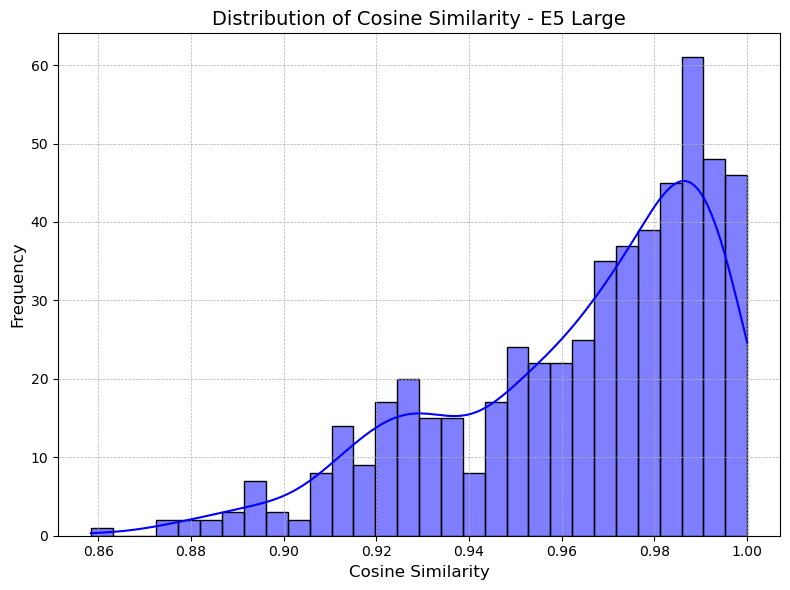

Model: LLaMA 3
Mean Cosine Similarity: 0.9446
Minimum Cosine Similarity: 0.7243
Mean Non-Parallel Cosine Similarity: 0.8817
P-value for Paired T-Test (Parallel vs Non-Parallel): 6.1640e-101
Percentage of Cosine Similarity < 0.95: 43.575%
Percentage of Cosine Similarity >= 0.95: 56.425%
Percentage of Cosine Similarity < 0.98: 55.307%
Percentage of Cosine Similarity >= 0.98: 44.693%



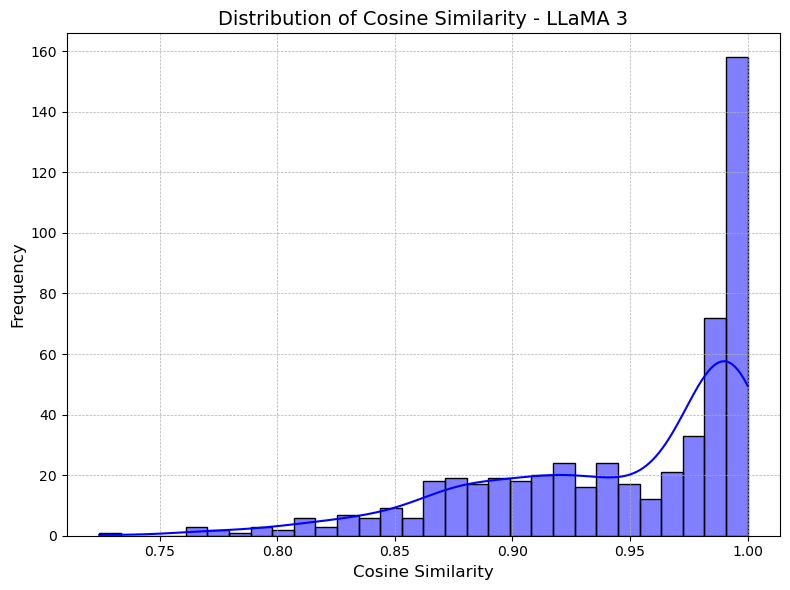

Model: AlephBERT
Mean Cosine Similarity: 0.9094
Minimum Cosine Similarity: 0.5895
Mean Non-Parallel Cosine Similarity: 0.6384
P-value for Paired T-Test (Parallel vs Non-Parallel): 1.0036e-275
Percentage of Cosine Similarity < 0.95: 56.611%
Percentage of Cosine Similarity >= 0.95: 43.389%
Percentage of Cosine Similarity < 0.98: 83.24%
Percentage of Cosine Similarity >= 0.98: 16.76%



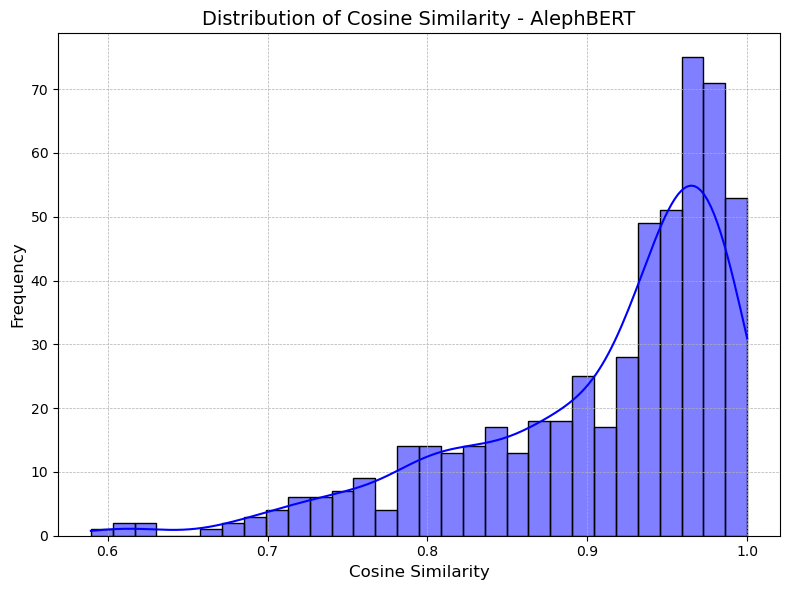

Model: MPNet
Mean Cosine Similarity: 0.8934
Minimum Cosine Similarity: 0.3871
Mean Non-Parallel Cosine Similarity: 0.6509
P-value for Paired T-Test (Parallel vs Non-Parallel): 9.2214e-199
Percentage of Cosine Similarity < 0.95: 55.493%
Percentage of Cosine Similarity >= 0.95: 44.507%
Percentage of Cosine Similarity < 0.98: 74.86%
Percentage of Cosine Similarity >= 0.98: 25.14%



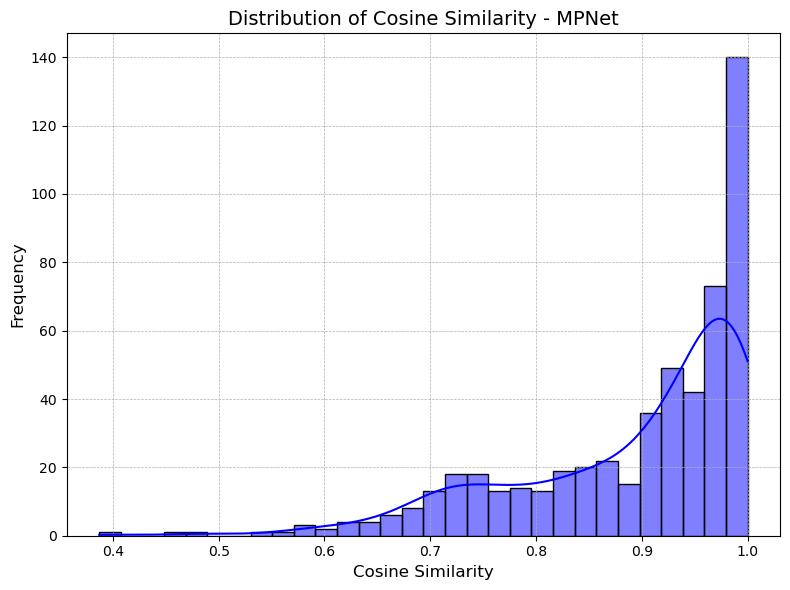

Model: LaBSE
Mean Cosine Similarity: 0.8134
Minimum Cosine Similarity: 0.1403
Mean Non-Parallel Cosine Similarity: 0.3812
P-value for Paired T-Test (Parallel vs Non-Parallel): 3.4958e-224
Percentage of Cosine Similarity < 0.95: 73.929%
Percentage of Cosine Similarity >= 0.95: 26.071%
Percentage of Cosine Similarity < 0.98: 88.454%
Percentage of Cosine Similarity >= 0.98: 11.546%



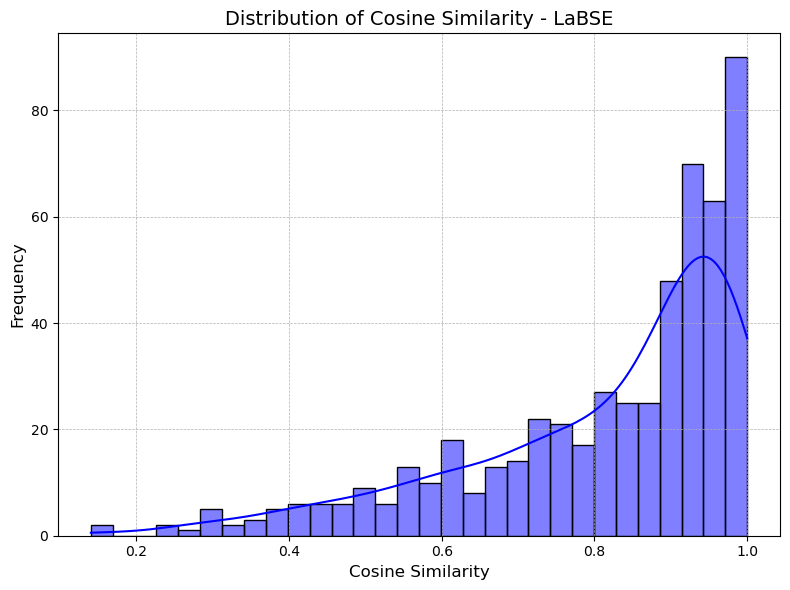

In [12]:
embeddings_summary(e5_large_cosine_scores, "E5 Large")
embeddings_summary(llama3_cosine_scores, "LLaMA 3")
embeddings_summary(alephbert_cosine_scores, "AlephBERT")
embeddings_summary(mpnet_cosine_scores, "MPNet")
embeddings_summary(labse_cosine_scores, "LaBSE")

## B. Summary Function for All Models
The `create_summary_table()` function summaries the same information as above, but instead of creating a histogram and summary for an individual model, it take in multiple models as a dictionary and summarizes them in one table.

In [13]:
import pandas as pd

def create_summary_table(models):
    # Initialize an empty list to store summary data for each model
    summary_data = []

    # Loop through each model, compute the summary statistics, and store the results
    for model_name, model_data in models.items():
        mean_cosine = model_data["Cosine_Similarity"].mean()
        min_cosine = model_data["Cosine_Similarity"].min()
        mean_non_parallel = model_data["Avg_Non_Parallel_Cosine_Similarity"].mean()
        p_value = perform_paired_t_test(model_data)
        cosine_below_95 = round(model_data[model_data['Cosine_Similarity'] < 0.95].shape[0] / len(model_data) * 100, 3)
        cosine_above_95 = round(model_data[model_data['Cosine_Similarity'] >= 0.95].shape[0] / len(model_data) * 100, 3)
        cosine_below_98 = round(model_data[model_data['Cosine_Similarity'] < 0.98].shape[0] / len(model_data) * 100, 3)
        cosine_above_98 = round(model_data[model_data['Cosine_Similarity'] >= 0.98].shape[0] / len(model_data) * 100, 3)

        # Append the summary statistics for the current model
        summary_data.append({
            "Model": model_name,
            "Mean Cosine Similarity": f"{mean_cosine:.4f}",
            "Min Cosine Similarity": f"{min_cosine:.4f}",
            "Mean Non-Parallel Cosine Similarity": f"{mean_non_parallel:.4f}",
            "P-value": f"{p_value:.4e}",
            "% Cosine < 0.95": f"{cosine_below_95}%",
            "% Cosine >= 0.95": f"{cosine_above_95}%",
            "% Cosine < 0.98": f"{cosine_below_98}%",
            "% Cosine >= 0.98": f"{cosine_above_98}%"
        })

    # Create a DataFrame from the collected summary data
    summary_df = pd.DataFrame(summary_data)

    # Format the DataFrame for better readability (e.g., setting index to model names)
    summary_df.set_index("Model", inplace=True)

    return summary_df

In [14]:
model_dfs = {
    "AlephBERT": alephbert_cosine_scores,
    "E5": e5_large_cosine_scores,
    "MPNET": mpnet_cosine_scores,
    "LaBSE": labse_cosine_scores,
    "Llama3":llama3_cosine_scores

}

create_summary_table(model_dfs)

,Mean Cosine Similarity,Min Cosine Similarity,Mean Non-Parallel Cosine Similarity,P-value,% Cosine < 0.95,% Cosine >= 0.95,% Cosine < 0.98,% Cosine >= 0.98
Model,,,,,,,,
AlephBERT,0.9094,0.5895,0.6384,1.0036e-275,56.611%,43.389%,83.24%,16.76%
E5,0.9636,0.8584,0.8856,9.9621e-253,27.687%,72.313%,61.566%,38.434%
MPNET,0.8934,0.3871,0.6509,9.2214e-199,55.493%,44.507%,74.86%,25.14%
LaBSE,0.8134,0.1403,0.3812,3.4958e-224,73.929%,26.071%,88.454%,11.546%
Llama3,0.9446,0.7243,0.8817,6.1640e-101,43.575%,56.425%,55.307%,44.693%


# V. Cosine Similarities Histograms for Parallel and Non-Parallels

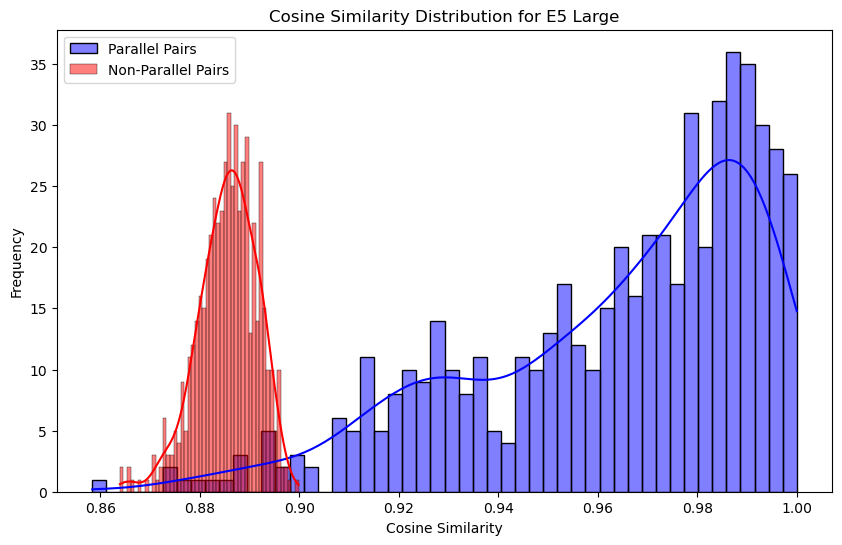

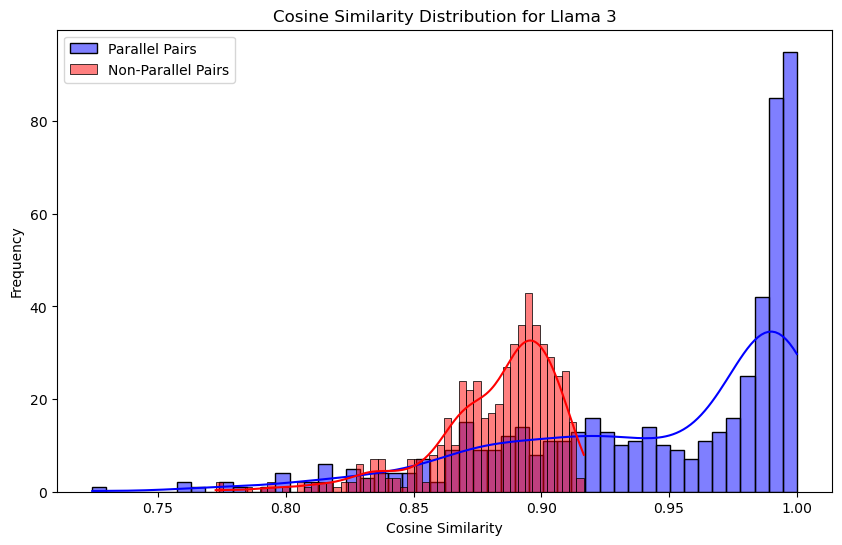

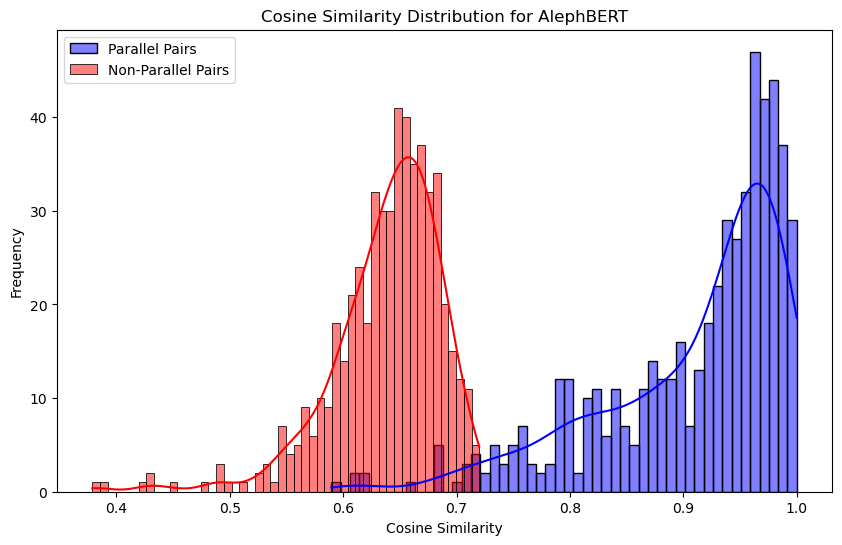

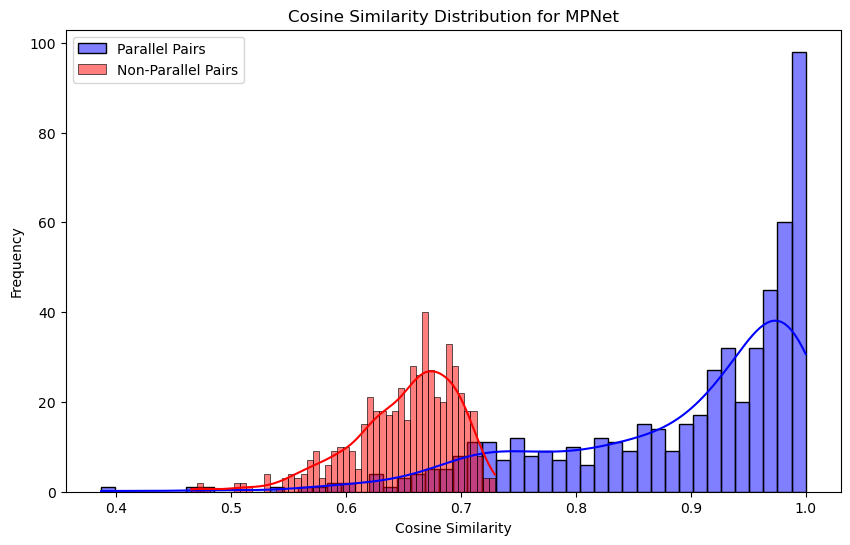

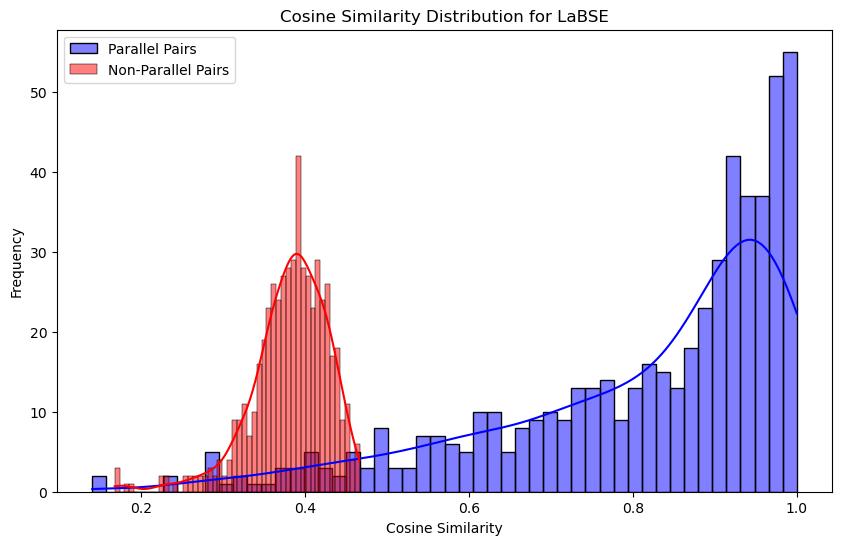

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot the distribution of cosine similarities for parallel and non-parallel pairs
def plot_cosine_similarity_distribution(model_name, model_scores, parallel_col='Cosine_Similarity', non_parallel_col='Avg_Non_Parallel_Cosine_Similarity'):
    # Set the figure size for the plot
    plt.figure(figsize=(10, 6))

    # Plot histogram for parallel pairs' cosine similarities (in blue), adding KDE for smoothness
    sns.histplot(model_scores[parallel_col], color='blue', label='Parallel Pairs', kde=True, bins=50)

    # Plot histogram for non-parallel pairs' cosine similarities (in red), also with KDE
    sns.histplot(model_scores[non_parallel_col], color='red', label='Non-Parallel Pairs', kde=True, bins=50)

    # Add title and labels for the plot
    # Label the x-axis
    # Label the y-axis
    # Display the legend to differentiate parallel vs non-parallel pairs
    # Show the plot
    plt.title(f'Cosine Similarity Distribution for {model_name}')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


plot_cosine_similarity_distribution('E5 Large', e5_large_cosine_scores)
plot_cosine_similarity_distribution('Llama 3', llama3_cosine_scores)
plot_cosine_similarity_distribution('AlephBERT', alephbert_cosine_scores)
plot_cosine_similarity_distribution('MPNet', mpnet_cosine_scores)
plot_cosine_similarity_distribution('LaBSE', labse_cosine_scores)

# VI. Distance between Distribution Measures
- Wasserstein Distance: Good for visualizing how "far apart" the two distributions are. A higher distance means better separation.
- KL Divergence: Useful if you want to quantify the "information loss" when using the non-parallel distribution to approximate the parallel distribution. This metric is asymmetric, so be mindful when interpreting it.
- KS Test: A non-parametric test that gives you a direct statistic on whether the two distributions are different. Ideal for significance testing.
- Bhattacharyya Distance: Gives a measure of overlap between distributions. The higher the distance, the less overlap.
- Overlap Coefficient: A direct measure of the shared area between the two distributions. Lower values mean better separation.

In [16]:
from scipy.stats import wasserstein_distance, entropy, ks_2samp
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate all the metrics for a single model
def calculate_metrics(model_name, parallel_scores, non_parallel_scores, bins=100):
    print(f"\n--- Metrics for {model_name} ---")

    # Wasserstein Distance
    distance = wasserstein_distance(parallel_scores, non_parallel_scores)
    print(f'Wasserstein Distance: {distance:.4f}')

    # KL Divergence
    parallel_hist, bin_edges = np.histogram(parallel_scores, bins=bins, density=True)
    non_parallel_hist, _ = np.histogram(non_parallel_scores, bins=bin_edges, density=True)

    # Add a small constant to avoid division by zero in KL divergence calculation
    epsilon = 1e-10
    parallel_hist += epsilon
    non_parallel_hist += epsilon

    kl_divergence = entropy(parallel_hist, non_parallel_hist)
    print(f'KL Divergence: {kl_divergence:.4f}')

    # KS Test
    ks_stat, p_value = ks_2samp(parallel_scores, non_parallel_scores)
    print(f'KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}')

    # Bhattacharyya Distance
    parallel_hist /= np.sum(parallel_hist)  # Normalize the histograms
    non_parallel_hist /= np.sum(non_parallel_hist)
    bc = np.sum(np.sqrt(parallel_hist * non_parallel_hist))  # Bhattacharyya coefficient
    bhattacharyya_dist = -np.log(bc) if bc > 0 else np.inf
    print(f'Bhattacharyya Distance: {bhattacharyya_dist:.4f}')

    # Overlap Coefficient
    overlap = np.sum(np.minimum(parallel_hist, non_parallel_hist))
    print(f'Overlap Coefficient: {overlap:.4f}')

# Wrapper function to run the metrics for all models
def run_all_metrics_for_models(models, model_data, parallel_col='Cosine_Similarity', non_parallel_col='Avg_Non_Parallel_Cosine_Similarity'):
    for model_name in models:
        # Extract parallel and non-parallel scores for each model
        parallel_scores = model_data[model_name][parallel_col]
        non_parallel_scores = model_data[model_name][non_parallel_col]

        # Call the function to calculate metrics for the model
        calculate_metrics(model_name, parallel_scores, non_parallel_scores)

# Example usage with models
models = ['E5-Large', 'AlephBERT', 'LLaMA3', 'MpNet', 'Labse']  # List of model names
model_data = {
    'E5-Large': e5_large_cosine_scores,   # Assuming this is your DataFrame with parallel and non-parallel scores
    'AlephBERT': alephbert_cosine_scores,
    'LLaMA3': llama3_cosine_scores,
    'MpNet': mpnet_cosine_scores,
    'Labse': labse_cosine_scores
}

# Run metrics for all models
run_all_metrics_for_models(models, model_data)


--- Metrics for E5-Large ---
Wasserstein Distance: 0.0780
KL Divergence: 24.5746
KS Statistic: 0.9672, p-value: 0.0000
Bhattacharyya Distance: 2.1110
Overlap Coefficient: 0.0328

--- Metrics for AlephBERT ---
Wasserstein Distance: 0.2710
KL Divergence: 23.6973
KS Statistic: 0.9646, p-value: 0.0000
Bhattacharyya Distance: 2.4070
Overlap Coefficient: 0.0341

--- Metrics for LLaMA3 ---
Wasserstein Distance: 0.0639
KL Divergence: 18.0645
KS Statistic: 0.7132, p-value: 0.0000
Bhattacharyya Distance: 0.7207
Overlap Coefficient: 0.2626

--- Metrics for MpNet ---
Wasserstein Distance: 0.2428
KL Divergence: 21.7154
KS Statistic: 0.8939, p-value: 0.0000
Bhattacharyya Distance: 1.3243
Overlap Coefficient: 0.1006

--- Metrics for Labse ---
Wasserstein Distance: 0.4324
KL Divergence: 22.3270
KS Statistic: 0.9348, p-value: 0.0000
Bhattacharyya Distance: 1.6047
Overlap Coefficient: 0.0596
